# Capstone Project - Product Classification Using Machine Learning

This project uses product data from an e-commerce company named The Otto Group to attempt to classify each of their products into 9 different categories. The idea for the project came from a [Kaggle](https://www.kaggle.com/c/otto-group-product-classification-challenge) competition.

### Load Data

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('train.csv')

# Dropping the id column and storing target separately
target = data['target'].str.slice(-1)
features = data.drop(['target','id'], axis=1)

print('Features shape: ', features.shape)
features.head()

Features shape:  (61878, 93)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,6,1,5,0,0,1,...,22,0,1,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


### Analyze Data

In [37]:
# Show which features have the highest and lowest mean counts as well as the overall max value.
print('Highest mean feature: ', features.mean().idxmax(), features.mean().max())
print('Lowest mean feature: ', features.mean().idxmin(), features.mean().min())
print('Overall max value: ', features.max().idxmax(), features.max().max())

Highest mean feature:  feat_67 2.89765344711
Lowest mean feature:  feat_6 0.0256957238437
Overall max value:  feat_73 352


The below snippet uses PCA to perform feature reduction to 5 components and then see which of the features contribute the most to the variance to have some knowledge of the most important features. The basis for this code was taken from the customer segement project https://github.com/udacity/machine-learning/blob/master/projects/customer_segments/visuals.py.

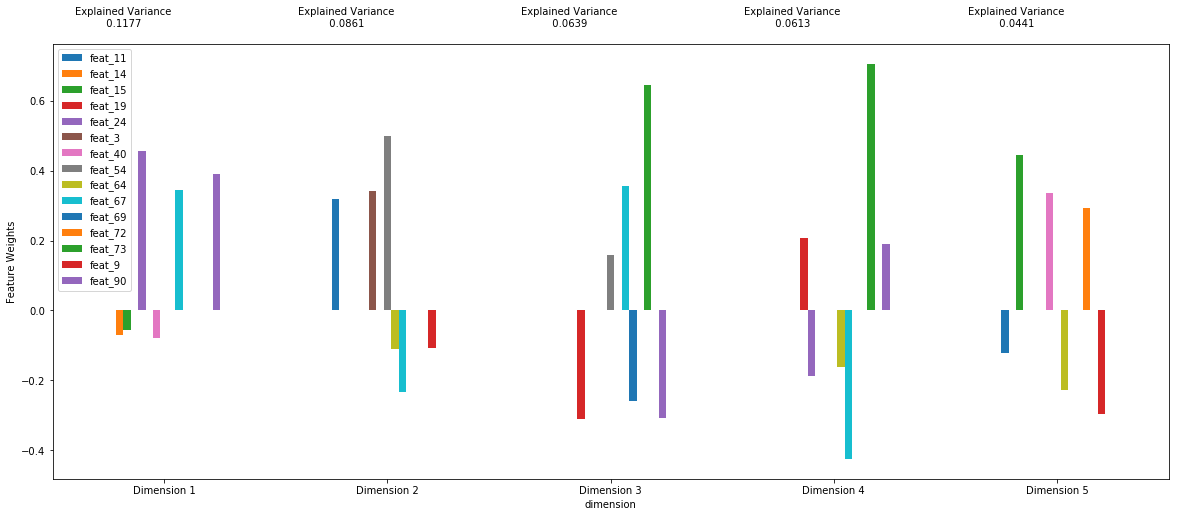

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline 

def pca_results(good_data, pca):

    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions
    
    def get_top_bottom_features(comp, dim):
        c = pd.concat([comp.loc[dim].nlargest(3), comp.loc[dim].nsmallest(3)])
        c = c.to_frame('value').reset_index().rename(columns={'index': 'feature'}).assign(dimension=dim)
        c = c.pivot(index='dimension', columns='feature', values='value')
        return c
    
    important_components = [get_top_bottom_features(components, d) for d in dimensions]
    important_components = pd.concat(important_components)
    
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (20,8))

    # Plot the feature weights as a function of the components
    important_components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca = PCA(n_components=5)
pca.fit(features)

pca_results = pca_results(features, pca)

### Preprocess Data

In [5]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 13)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 49502 samples.
Testing set has 12376 samples.


### XGBoost
The classifer will first be run with the default parameters then using GridSearch a few parameters will be refined to arrive at an optimized model.

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.model_selection import GridSearchCV

def calculate_metrics(model):
    # Predict model and calculate accurracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100.0))

    # Predict model probabilities for each class and calculate log loss
    y_pred_prob = model.predict_proba(X_test)
    loss = log_loss(y_test, y_pred_prob)
    print("Log Loss: {:.4f}".format(loss))

In [13]:
# Build model and fit
xgboost_model = XGBClassifier(objective = 'multi:softmax')
xgboost_model.fit(X_train, y_train)

calculate_metrics(xgboost_model)

Accuracy: 77.34%
Log Loss: 0.6477


Next we attempt to refine the model using GridSearch to find the best parameters for the classifier.

In [6]:
# Now attempt to refine the model using GridSearch to find the best model
xgboost_model = XGBClassifier(objective = 'multi:softmax')

# Parameters to attempt
parameters = {'n_estimators': [50, 200], 'max_depth': [2, 5], 'learning_rate': [0.01, 0.2]}

scorer = make_scorer(log_loss, greater_is_better = False, needs_proba = True)

grid = GridSearchCV(xgboost_model, parameters, scorer)
grid_fit = grid.fit(X_train, y_train)

best_xgboost = grid_fit.best_estimator_

calculate_metrics(best_xgboost)

Accuracy: 81.61%
Log Loss: 0.4814


In [9]:
print(best_xgboost)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


### AdaBoost
The classifer will first be run with the default parameters then using GridSearch a few parameters will be refined to arrive at an optimized model.

In [15]:
from sklearn.ensemble import AdaBoostClassifier

In [27]:
# Build model and fit
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train, y_train)

calculate_metrics(adaboost_model)

Accuracy: 69.12%
Log Loss: 2.0214


Next we attempt to refine the model using GridSearch to find the best parameters for the classifier.

In [19]:
# Now attempt to refine the model using GridSearch to find the best model
adaboost_model = AdaBoostClassifier()

# Parameters to attempt
parameters = {'n_estimators': [25, 100, 200], 'learning_rate': [1, 0.75, 0.5]}

scorer = make_scorer(log_loss, greater_is_better = False, needs_proba = True)

grid = GridSearchCV(adaboost_model, parameters, scorer)
grid_fit = grid.fit(X_train, y_train)

best_adaboost = grid_fit.best_estimator_

calculate_metrics(best_adaboost)

Accuracy: 65.74%
Log Loss: 1.9627


In [21]:
print(best_adaboost)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=25, random_state=None)


### Neural Network
The classifer will first be run with the default parameters then using GridSearch a few parameters will be refined to arrive at an optimized model.

In [23]:
from sklearn.neural_network import MLPClassifier

In [28]:
# Build model and fit
nn_model = MLPClassifier()
nn_model.fit(X_train, y_train)

calculate_metrics(nn_model)

Accuracy: 79.03%
Log Loss: 0.6685


Next we attempt to refine the model using GridSearch to find the best parameters for the classifier.

In [29]:
# Now attempt to refine the model using GridSearch to find the best model
nn_model = MLPClassifier()

# Parameters to attempt
parameters = {'hidden_layer_sizes': [(200,), (100, 100), (200, 200) ], 
              'activation': ['relu', 'logistic'],
              'learning_rate_init': [0.001, 0.01, 0.1]
             }

scorer = make_scorer(log_loss, greater_is_better = False, needs_proba = True)

grid = GridSearchCV(nn_model, parameters, scorer)
grid_fit = grid.fit(X_train, y_train)

best_nn = grid_fit.best_estimator_

calculate_metrics(best_nn)

/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Accuracy: 75.50%
Log Loss: 0.6542


In [30]:
print(best_nn)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


### Model Validation

The XGBoost model appears to be the best model based on accuracy and log loss. To validate the model, multiple train/test splits will be performed to ensure differences in the training data don't affect the quality of the model.

In [35]:
log_losses = []
accuracies = []

def train_model():
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)
    
    # Create XGBClassifier using the parameters found from GridSearch
    xgboost_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.2)
    xgboost_model.fit(X_train, y_train)

    # Predict model and calculate accurracy
    y_pred = xgboost_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print("Accuracy: {:.2f}%".format(accuracy * 100.0))

    # Predict model probabilities for each class and calculate log loss
    y_pred_prob = xgboost_model.predict_proba(X_test)
    loss = log_loss(y_test, y_pred_prob)
    log_losses.append(loss)
    print("Log Loss: {:.4f}".format(loss))
    
for i in range(5):
    train_model()

Accuracy: 81.18%
Log Loss: 0.4879
Accuracy: 80.80%
Log Loss: 0.5014
Accuracy: 80.74%
Log Loss: 0.4987
Accuracy: 81.37%
Log Loss: 0.4842
Accuracy: 81.53%
Log Loss: 0.4834


In [40]:
print("Average Accuracy: {:.2f}%".format(np.mean(accuracies) * 100.0))
print("Average Log Loss: {:.4f}".format(np.mean(log_losses)))

Average Accuracy: 81.12%
Average Log Loss: 0.4911


Below is a visualization of the most important features in the final XGBoost model.

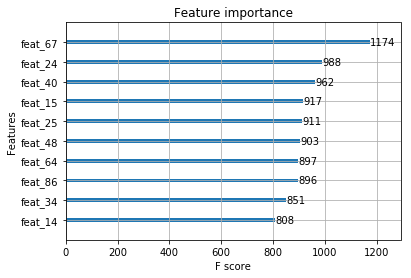

In [6]:
from xgboost import plot_importance

best_xgboost = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.2)
best_xgboost.fit(X_train, y_train)

plot_importance(best_xgboost, max_num_features=10)